In [1]:
import numpy as np
np.random.seed(1001)

import os
import sys
import shutil

import IPython
import IPython.display as ipd  # To play sound in the notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from tqdm import tqdm_notebook, tqdm
import tqdm

import librosa 
import wave

import torch 
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

from torchvision import transforms, utils

from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Linear, ReLU, LeakyReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, AdaptiveMaxPool2d
from torch.nn import Softmax, LogSoftmax, BatchNorm1d, BatchNorm2d, Dropout, Flatten
from torch.nn import CrossEntropyLoss, NLLLoss
from torch.optim import Adam, SGD

from torch.utils.tensorboard import SummaryWriter


dataset_path = '/home/renault/Projects/Statet-of-the-Art/Dataset/freesound-audio-tagging/'

/home/renault/env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/renault/env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/renault/env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/renault/env/lib/python3.5/site-packages/tensorboard/compat/tensorflow_

## 1. Exploratory Data Analysis

### Load data

In [2]:
# ## load dataset and save as dataframe
# train = pd.read_csv(os.path.join(dataset_path,"train.csv"))
# test = pd.read_csv(os.path.join(dataset_path,"test_post_competition.csv"))

In [3]:
# print("Number of training examples=", train.shape[0], "  Number of classes in training set=", len(train.label.unique()))
# print("Number of test examples=", test.shape[0], "  Number of classes in test set=", len(test.label.unique()))
# train.head()

### Distribution of Categories

In [4]:
# category_group = train.groupby(['label', 'manually_verified']).count()
# plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
#           .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
# plot.set_xlabel("Category")
# plot.set_ylabel("Number of Samples")
# print('Minimum samples per category = ', min(train.label.value_counts()))
# print('Maximum samples per category = ', max(train.label.value_counts()))

### Test listening audio 

In [5]:
# fname = dataset_path + 'audio_train/' + '00044347.wav'   # Hi-hat
# ipd.Audio(fname)

In [6]:
# ## plot wave using librosa 
# wav, sr = librosa.load(fname)
# print("Sampling (frame) rate = ", sr)
# print("Total samples (frames) = ", len(wav))
# print("Duration = ", len(wav)/sr)

# ## plot audio frames
# plt.plot(wav, 'r--')
# plt.title("Audio frames")
# plt.show()

# ## zoom in on first 500 frames
# plt.figure(figsize=(16,4))
# plt.plot(wav[:500],'--')
# plt.plot(wav[:500],'.')
# plt.title("First 500 frames")
# plt.show()

### Audio Length Distribution

In [7]:
# train['nframes'] = train['fname'].apply(lambda f: wave.open(dataset_path+'audio_train/' + f).getnframes())
# test['nframes'] = test['fname'].apply(lambda f: wave.open(dataset_path+'audio_test/' + f).getnframes())

In [8]:
# train.head()

In [9]:
# _, ax = plt.subplots(figsize=(16, 4))
# sns.violinplot(ax=ax, x="label", y="nframes", data=train)
# plt.xticks(rotation=90)
# plt.title('Distribution of audio frames, per label', fontsize=16)
# plt.show()

In [10]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
# train.nframes.hist(bins=100, ax=axes[0])
# test.nframes.hist(bins=100, ax=axes[1])
# plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large')

# 2. Building from scratch a simple CNN-2D using MFCCs

### Loading audio using Torch Audio

Sampling (frame) rate =  44100
Total samples (frames) =  617400
Duration =  14.0


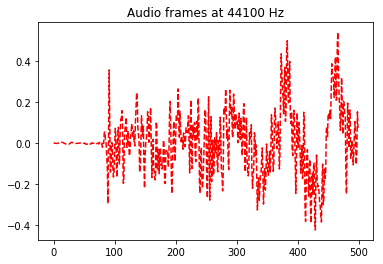

torch.Size([224000, 1])
224000


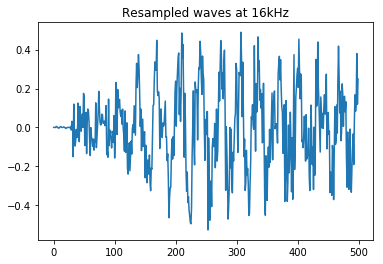

In [25]:
fname = dataset_path + 'audio_train/' + '00044347.wav'   # Hi-hat
wav, sr = torchaudio.load(fname)  ## wav is now a tensor, not an array
print("Sampling (frame) rate = ", sr)
print("Total samples (frames) = ", wav.size(1))
print("Duration = ", wav.size(1)/sr)

## plot audio frames
plt.plot(wav.t().numpy()[:500], 'r--')
plt.title("Audio frames at %d Hz" % sr)
plt.show()

# ## zoom in on first 500 frames
# plt.figure(figsize=(16,4))
# plt.plot(wav[:500],'--')
# plt.plot(wav[:500],'.')
# plt.title("First 500 frames")
# plt.show()

resampled_wav = torchaudio.transforms.Resample(sr, 16000)(wav)
print(resampled_wav.t().size())
print(resampled_wav.size(1))
plt.plot(resampled_wav.t()[:500].numpy())
plt.title("Resampled waves at 16kHz")
plt.show()

### Generating MFCC using Librosa

In [16]:
mfcc = librosa.feature.mfcc(wav.t().numpy().squeeze()[:sr*2], sr = sr, n_mfcc = 40, hop_length=512)
mfcc.shape

(40, 173)

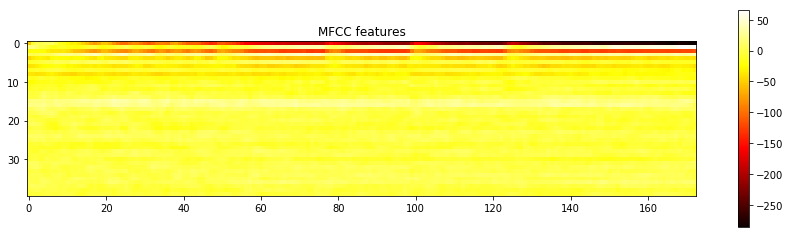

In [21]:
plt.figure(figsize=(15,4))
plt.imshow(mfcc, cmap = 'hot', interpolation = 'nearest')
plt.colorbar()
plt.title("MFCC features")
plt.show()

(40, 63)


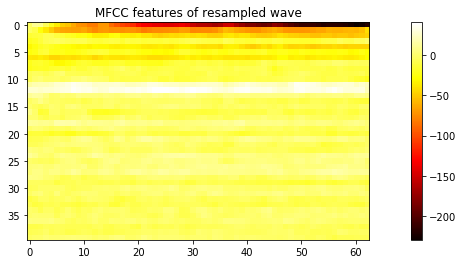

In [22]:
resampled_mfcc = librosa.feature.mfcc(resampled_wav.t().numpy().squeeze()[:16000*2], sr = 16000, n_mfcc = 40, hop_length=512)
print(resampled_mfcc.shape)
plt.figure(figsize=(15,4))
plt.imshow(resampled_mfcc, cmap = 'hot', interpolation = 'nearest')
plt.colorbar()
plt.title("MFCC features of resampled wave")
plt.show()

### Generating MFCC using torch.audio

In [46]:
wav[:,:sr*2].size()

torch.Size([1, 88200])

torch.Size([198, 13])


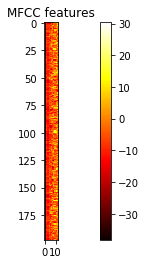

In [63]:
mfcc = torchaudio.compliance.kaldi.mfcc(resampled_wav[:,:32000])
print(mfcc.size())
plt.figure(figsize=(15,4))
plt.imshow(mfcc, cmap = 'hot', interpolation = 'nearest')
plt.colorbar()
plt.title("MFCC features")
plt.show()

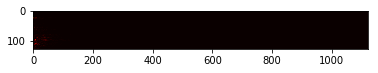

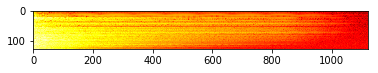

torch.Size([1, 128, 1121])


In [67]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram()(resampled_wav[:3200])
plt.imshow(mel_spectrogram[0,:,:].detach().numpy(),cmap='hot')
plt.show()
mel_spectrogram[0,:,:] = mel_spectrogram.log2()[0,:,:]
plt.imshow(mel_spectrogram[0,:,:].detach().numpy(),cmap='hot')
plt.show()
print(mel_spectrogram.size())

### Prepare training dataset

In [12]:
# classes = train['label'].unique()
# print(classes)
# list(classes).index('Saxophone')

In [2]:
class AudioDataset(Dataset):
    
    def __init__(self, csv_file, root_dir=None, sampling_rate=44100, is_labeled = True, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sampling_rate = sampling_rate
        self.is_labeled = is_labeled
        
        print("Nb of training samples = ", self.__len__())
#         print(transform)
        if self.is_labeled :
            self.all_classes = list(self.data['label'].unique())
            self.n_classes = len(self.all_classes)
            print('Nb of classes = ', self.n_classes)

    ## len(dataset) return the size of dataset    
    def __len__(self):
        return self.data.shape[0]
    
    def get_classes(self):
        return self.all_classes
    
    ## dataset[i] return the ith sample
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        fname = os.path.join(self.root_dir,
                            self.data.iloc[idx,0])
        
        wav, sr = torchaudio.load(fname, normalization=True)  ## wav is a tensor, not an array
        ## Resampling with new sampling_rate
        sample = torchaudio.transforms.Resample(sr, self.sampling_rate)(wav)
#         sample = wav.t()
        
        ## Random offset + Padding + Normalization
        if self.transform :
#             sample_wave = self.transform[0](sample)
            sample_features = self.transform(sample)

            if self.is_labeled:
                label_name = self.data.iloc[idx,1]
                label = self.all_classes.index(label_name)
                return {'features':sample_features, 'label':label}

            else : 
                return {'features':sample_features}
        
        else:
            return {'raw_signal':sample}
    
        
# ### Test 

# audio_ds= AudioDataset(csv_file = os.path.join(dataset_path,"train.csv"),
#                       root_dir  = dataset_path + 'audio_train/',
#                       sampling_rate = 16000,
#                       is_labeled = True)
# classes = audio_ds.get_classes()
# print(len(audio_ds))
# for i in range(3):
#     sample = audio_ds[i]
#     print(sample['raw_signal'].size())
#     ## plot audio frames
#     plt.plot(sample['raw_signal'].t().numpy(), 'r--')
#     plt.title("Audio frames " + str(i) + ": " + classes[(sample['label'])])
#     plt.show()

class Random_Sample(object):
    
    def __init__(self, sample_duration, sampling_rate):
        self.sample_length = sample_duration * sampling_rate

    def __call__(self, sample):
        original_audio_length = sample.size(1)
        sample = sample.t()
        ## random offset / Padding
        if original_audio_length > self.sample_length:
            max_offset = original_audio_length - self.sample_length
            offset = np.random.randint(max_offset)
            new_sample = sample[offset:(offset+self.sample_length)].numpy()
        else:
            if original_audio_length == self.sample_length:
                offset = 0
            else: 
                max_offset = self.sample_length - original_audio_length
                offset = np.random.randint(max_offset)
            ## zero padding 
            new_sample = np.pad(sample.numpy()[:,0], (offset, self.sample_length - original_audio_length - offset), "constant")
                
        ## Normalize
        max_val = np.max(new_sample)
        min_val = np.min(new_sample)
    
        new_sample = (new_sample - min_val)/(max_val - min_val + 1e-6)
        new_sample -= 0.5
        
        return torch.from_numpy(new_sample.reshape(1,-1))
    
class MFCC_Features(object):
    def __init__(self,sampling_rate):
        self.sampling_rate = sampling_rate
    def __call__(self,sample):
        mfcc = torchaudio.compliance.kaldi.mfcc(sample,sample_frequency=self.sampling_rate)
        return mfcc

class Spectrogram(object):
    def __init__(self,sampling_rate):
        self.sampling_rate = sampling_rate
    def __call__(self,sample):
        spectrogram = torchaudio.transforms.Spectrogram()(sample)
        spectrogram[0,:,:] = spectrogram.log2()[0,:,:]
        return spectrogram
    
class LogMelSpectrogram(object):
    def __init__(self,sampling_rate):
        self.sampling_rate = sampling_rate
    def __call__(self,sample):
        mel_spectrogram = torchaudio.transforms.MelSpectrogram()(sample)
        mel_spectrogram[0,:,:] = mel_spectrogram.log2()[0,:,:]
        mel_spectrogram[mel_spectrogram == -float('inf')] = 0.0
        return mel_spectrogram


### Test 

sampling_rate = 16000
transformed_audio_ds= AudioDataset(csv_file = os.path.join(dataset_path,"train.csv"),
                                   root_dir  = dataset_path + 'audio_train/',
                                   sampling_rate = sampling_rate,
                                   transform=transforms.Compose(
                                       [Random_Sample(sample_duration=2,sampling_rate=sampling_rate),
                                        LogMelSpectrogram(sampling_rate = sampling_rate)])
                                  )
classes = transformed_audio_ds.get_classes()

Nb of training samples =  9473
Nb of classes =  41


In [28]:
#

torch.Size([1, 128, 161])
tensor([ 0.0000, -3.2227, -0.7940,  0.0000, -4.9624, -4.7480,  0.0000, -4.1306,
        -7.3215, -4.5452, -4.3414, -6.2529, -3.5883,  0.0000, -3.4051, -6.7406,
        -3.4632, -5.2683, -4.3579, -5.7917, -7.2707, -8.9383, -1.4205, -3.8732,
        -1.9382, -2.6192, -1.1900, -1.5619, -1.9377,  2.0887, -1.2684, -7.2188,
        -4.9452, -1.3011,  0.2026, -0.2167, -1.8132, -3.3045, -2.2291, -2.1264,
        -1.1551, -0.3613,  1.2772,  0.3287, -0.9419, -2.5872, -3.8125, -2.5302,
        -1.6613, -2.4219, -0.3237,  0.2183, -1.7875, -3.7976, -5.5703, -2.4855,
         1.6987,  4.4940,  3.4554, -0.5230, -1.0296, -2.7492,  2.7668,  4.4704,
         3.3994,  5.4981,  4.2291,  0.4261,  3.5192,  4.2120,  3.1411,  3.1520,
         3.2946,  1.2060, -2.1157, -0.0718,  1.1066,  1.0922,  1.2242,  2.2814,
         3.4714,  4.2418,  6.0572,  5.9249,  1.9014,  2.2305,  4.0563,  2.3073,
         3.6104,  4.7505,  4.3864,  3.6992,  1.4963, -1.4420,  3.2217,  4.7787,
         4.648

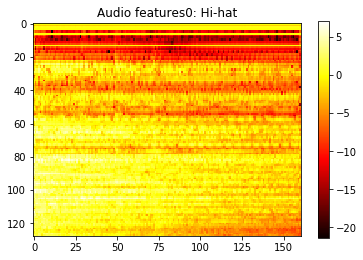

torch.Size([1, 128, 161])
tensor([  0.0000,  -3.8765,  -1.4477,   0.0000,  -0.3722,  -0.1578,   0.0000,
          0.9782,  -2.2128,   0.6743,   0.8780,   0.8109,   3.4755,   0.0000,
          5.5455,   2.2100,   5.6931,   3.8880,   3.6996,   2.2658,  -0.8788,
         -2.5464,  -1.5309,  -2.9504,   1.0641,   0.8362,   2.2655,   0.9694,
          0.5937, -14.2678,  -2.1282,  -0.9952,   0.3682,  -0.3355,   0.1752,
          0.1796,  -0.0565,   0.1715,  -1.4164,  -4.9928,  -5.2268,  -5.3229,
         -8.3567,  -4.2065,  -2.3230,  -1.7153,  -1.8042,  -3.8329, -10.2874,
         -6.3555,  -6.2956,  -7.3758,  -5.7168,  -1.9217,  -2.3211,  -4.6614,
         -9.1935,  -8.8352,  -9.7791,  -7.4181,  -5.5042,  -6.5776, -10.0770,
         -7.5116,  -3.9637,  -3.1991,  -4.0820,  -4.6951,  -5.3760,  -6.6054,
         -6.2741,  -7.0763, -12.2202,  -9.3455,  -6.8952,  -6.2169,  -6.1253,
         -6.2554,  -6.9456,  -8.8043,  -9.0194, -11.0819, -10.5422,  -8.8042,
        -10.1460, -11.2443, -10.0566, 

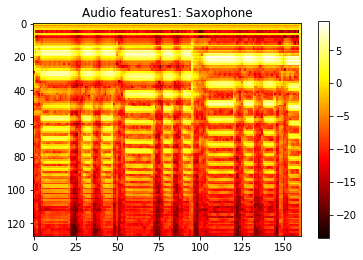

torch.Size([1, 128, 161])
tensor([  0.0000,   1.2219,   3.6506,   0.0000, -47.1264, -46.9120,   0.0000,
        -48.5184, -51.7094, -46.0914, -45.8877, -48.5066, -45.8419,   0.0000,
        -45.6368, -48.9723, -46.9519, -48.7570, -48.8249, -50.2588, -46.9193,
        -48.5870, -47.3586, -49.9222, -48.9973, -47.9355, -46.5062, -47.4843,
        -47.8601, -49.4904, -50.4921, -49.6701, -54.5785, -51.4464, -49.9587,
        -50.4655, -48.0968, -47.4134, -50.5137, -50.2401, -50.9781, -52.5474,
        -49.0793, -50.8899, -48.5130, -49.0307, -52.9522, -51.0028, -48.7095,
        -49.5113, -49.7463, -49.8283, -48.6527, -49.4993, -51.2575, -52.8785,
        -47.6708, -48.5568, -49.5922, -48.1086, -45.9509, -46.2154, -48.5476,
        -50.4311, -50.3744, -51.0681, -48.7628, -48.4981, -51.0372, -50.7431,
        -49.5164, -49.4659, -47.9101, -48.2429, -51.2481, -48.6639, -49.4830,
        -48.7301, -47.8222, -51.1388, -49.9601, -50.3635, -48.2199, -47.8215,
        -48.3081, -48.1781, -47.1185, 

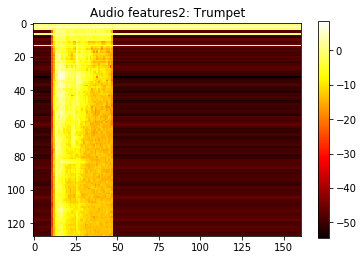

torch.Size([1, 128, 161])
tensor([  0.0000, -15.1840, -12.7553,   0.0000,  -3.0480,  -2.8336,   0.0000,
         -4.1217,  -7.3127,  -6.0308,  -5.8270,  -9.4096,  -6.7449,   0.0000,
         -4.8563,  -8.1918,  -2.9384,  -4.7435,  -4.0762,  -5.5100,  -4.8544,
         -6.5220,  -2.0848,  -4.5557,  -2.7410,  -8.1252,  -6.6960,  -2.2727,
         -2.6484,  -0.4729,  -2.4586,  -2.0237,  -3.8846,  -3.3290,  -2.1345,
         -0.4330,  -1.6609,  -2.2674,  -3.9449,  -5.7160,  -2.3092,  -1.0750,
          0.7523,  -6.6350,   7.2775,   9.8236,  10.5040,   9.4985,   0.7517,
          1.1126,  -1.7438,  -0.7611,  -2.6640,  -5.9730,  -7.4541,  -8.7200,
         -9.4887,  -4.7224,  -2.8566,  -1.9406,  -2.7132,  -3.6443,  -2.3005,
         -3.4360,  -3.1056,  -1.1113,  -0.2011,  -0.9387,  -1.6970,  -2.2338,
         -4.6768,  -4.1189,  -4.8943,  -5.1270,  -6.3236,  -6.0092,  -5.0929,
         -3.5833,  -3.3312,  -2.3932,  -4.3134,  -3.8714,  -2.7189,  -5.3421,
         -5.2547,  -4.4750,  -2.2756, 

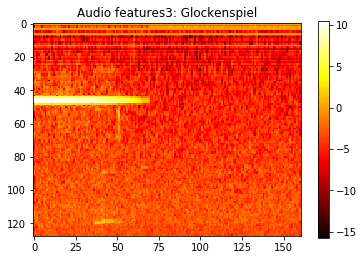

torch.Size([1, 128, 161])
tensor([  0.0000,   1.4605,   3.8892,   0.0000,   0.9745,   1.1889,   0.0000,
          2.5975,  -0.5934,   3.1080,   3.3117,   1.7786,   4.4432,   0.0000,
          2.0500,  -1.2855,   5.4841,   3.6790,   3.9232,   2.4894,   2.0119,
          0.3442,   1.1911,  -1.4739, -17.2496,  -8.9907,  -7.5615,   1.9656,
          1.5899,   3.6922,   2.5594,   3.3480,   4.5536,   5.9618,   7.3208,
          7.7623,   5.8254,  -7.7646,   6.1749,   4.4030,   4.3789,   4.4700,
          5.7627,   3.2099,   3.8962,   3.9300,   3.3121,   0.0476,  -0.3123,
          0.2993,   0.7784,  -1.7908,  -1.3847,  -0.8456,  -1.1138,   0.7331,
          2.7371,   1.8085,  -1.1067,  -5.1692,  -3.5852,  -2.3728,  -2.6959,
         -2.3614,  -3.8460,  -2.4989,  -0.1079,  -0.5947,  -0.1752,  -0.8931,
         -2.5266,  -2.5071,  -0.3510,  -0.6131,  -0.1173,   2.4309,   1.6161,
          0.1226,   0.0963,   0.4846,   1.6281,  -0.5400,  -5.1228,  -4.2901,
         -6.4550,  -4.4722,  -1.9909, 

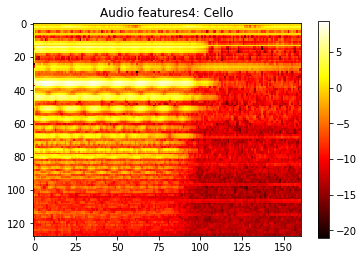

In [77]:
# print(len(transformed_audio_ds))
for i in range(5):
    sample = transformed_audio_ds[i]
#     print(sample['raw_signal'].size())
#     ## plot audio frames
#     plt.subplot(121)
#     plt.plot(sample['raw_signal'].t().numpy(), 'r--')
#     plt.title("Audio frames " + str(i) + ": " + classes[(sample['label'])])
#     ## plot features
#     plt.subplot(121)
    print(sample['features'].size())
    
#     new_f = F.softmax(sample['features'], dim=1)  
#     print(F.softmax(sample['features'], dim=1)[:,0])
    plt.imshow(sample['features'][0,:,:].detach().numpy(), cmap='hot')
    plt.title("Audio features" + str(i) + ": " + classes[(sample['label'])])
#     plt.subplot(122)
#     sample['features'][sample['features'] == -float('inf')] =  0
    print(sample['features'][0,:,0])

#     plt.imshow(sample['features'][0,:,:].detach().numpy(), cmap='hot')
    plt.colorbar()
    plt.show()
    

### Iterating through dataset using DataLoader

In [15]:
# def show_raw_wave_batch(sample_batched):
#     batch_size = sample_batched['raw_signal'].size(0)
#     for i in range(batch_size):
#         plt.plot(sample_batched['raw_signal'][i].t().numpy())
#         plt.show()

In [16]:
# batch_size = 3
# dataloader = DataLoader(transformed_audio_ds, batch_size = batch_size, shuffle =True, num_workers=4)

# # for i_batch, sample_batched in enumerate(dataloader):
# #     data, label = sample_batched['raw_signal'], sample_batched['label']
# #     print(i_batch, data.size(), label)
# #     if i_batch == 3 :
# #         show_raw_wave_batch(sample_batched)
# #         break
# dataloader = iter(dataloader)
# len(dataloader)


In [17]:
# sampled_batch = next(dataloader)
# print(sampled_batch['label'])

### Build model

In [18]:
# class Dummy_Conv1D_Net(Module):
    
#     def __init__(self):
#         super(Dummy_Conv1D_Net,self).__init__()
        
#         self.cnn_layers = Sequential(
#             ## First conv bloc
#             Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=0),
#             ReLU(inplace=True),
#             Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=0),
#             ReLU(inplace=True),
#             MaxPool1d(kernel_size=16),
#             Dropout(p=0.1),
#             Flatten()
            
#         )
        
#         self.linear_layers = Sequential(
#             Linear(in_features = 16*1999, out_features = 1024),
#             Linear(in_features = 1024, out_features = 41)
#         )
    
#     def forward(self,x):
#         x = self.cnn_layers(x)
# #         x = x.view((x.size(0), -1)) ## Flatten
# #         print(x.size())
#         x = self.linear_layers(x)
#         return x

# dummy_model = Dummy_Conv1D_Net()
# print(dummy_model)

In [4]:
class Conv2D_Net(Module):
    
    def __init__(self):
        super(Conv2D_Net,self).__init__()
        
        self.cnn_bloc_1 = Sequential(
            ## First conv bloc
            Conv2d(in_channels=1, out_channels=32, kernel_size=(4,10)),
            ReLU(),
            BatchNorm2d(num_features=32),
            MaxPool2d(kernel_size=2)        
        )
        
        self.cnn_bloc_2 = Sequential(
            ## second conv bloc
            Conv2d(in_channels=32, out_channels=32, kernel_size=(4,10)),
            ReLU(),
            BatchNorm2d(num_features=32),
            MaxPool2d(kernel_size=2)           
        )
        
        self.cnn_bloc_3 = Sequential(
            ## Third conv bloc
            Conv2d(in_channels=32, out_channels=32, kernel_size=(4,10)),
            ReLU(),
            BatchNorm2d(num_features=32),
            MaxPool2d(kernel_size=2)  
        )
        
        self.cnn_bloc_4 = Sequential(
            ## Fourth conv bloc
            Conv2d(in_channels=32, out_channels=32, kernel_size=(4,10)),
            ReLU(),
            BatchNorm2d(num_features=32),
            MaxPool2d(kernel_size=2),
            Flatten()
        )
        
        self.linear_layers = Sequential(
            Linear(in_features = 160, out_features = 64),
            ReLU(),
#             BatchNorm1d(num_features=64),
            Linear(in_features = 64, out_features = 41),
#             BatchNorm2d(num_features=41)
#             ReLU(),
#             Linear(in_features = 1028, out_features = 41)
#             LogSoftmax(dim=1)
        )
    
    def forward(self,x):
        x = self.cnn_bloc_1(x)
        x = self.cnn_bloc_2(x)
        x = self.cnn_bloc_3(x)
        x = self.cnn_bloc_4(x)
        x = self.linear_layers(x)
#         x = F.log_softmax(x)
        return x

conv2d_model = Conv2D_Net()
print(conv2d_model)

## Define loss function an optimizer
# criterion = NLLLoss()
criterion = CrossEntropyLoss()
optimizer = Adam(conv2d_model.parameters(), lr=0.001) #, weight_decay=1e-5)

Conv2D_Net(
  (cnn_bloc_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_bloc_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_bloc_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_bloc_4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, moment

### TensorBoard setup

In [5]:
writer = SummaryWriter('runs/conv2d_audio_test_1')
# writer.close()

### Train model

In [6]:
train_ds, val_ds = random_split(transformed_audio_ds, [8053,1420])

batch_size = 64

train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle =True)
val_dataloader = DataLoader(val_ds, batch_size = batch_size, shuffle =True)
train_batches = len(train_dataloader)
val_batches = len(val_dataloader)
# train_iter  = iter(train_dataloader)
# val_iter  = iter(val_dataloader)
# data, labels = next(iter(dataloader))
print(train_batches, val_batches)

126 23


In [8]:
# sample = next(train_iter)
# sample['label']

In [9]:
# for idx, sample in enumerate(train_dataloader):
#     print(idx, sample['label'])
#     if idx==3:
#         break

In [7]:
## Train model

# print("Adding model to tensorboard")
# sample_batched = next(train_dataloader)
# data, label = sample_batched['raw_signal'], sample_batched['label']
# writer.add_graph(conv1d_model, data)

model_added =  False 
num_epochs = 50
n_iter = 0
best_acc_loss = np.inf
checkpoint = train_batches

print("Start training...")
for epoch in range(num_epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs  = []

#     train_iter  = iter(train_dataloader)
#     val_iter  = iter(val_dataloader)
    
    print('Epoch %d/%d :' %(epoch +1, num_epochs))
#     print('[Training phase] : ', end='')
    
    for i_batch, sample_batched in tqdm.notebook.tqdm(enumerate(train_dataloader), total=train_batches):
#         sample_batched = next(train_iter)
        n_iter += 1
        data, label = sample_batched['features'], sample_batched['label']
        if not model_added:
            print("Adding model to tensorboard...\n")
            writer.add_graph(conv2d_model, data)
            model_added = True
            
#         conv1d_model.train()
        
        ## forward + backward + optimize
        outputs = conv2d_model(data)
        loss = criterion(outputs, label)
#         with autograd.detect_anomaly():
        loss.backward()
#         conv2d_model.float()
#         torch.nn.utils.clip_grad_norm_(conv2d_model.parameters(),0.5)

        optimizer.step()
        optimizer.zero_grad()
        
        ## compute statistics
        running_loss = loss.item()
        _, y_pred = torch.max(F.softmax(outputs, dim=1),1)
#         _, y_pred = torch.max(outputs.data,1)

#         print(y_pred, "vs ",label)
        correct = (y_pred == label).sum().item()
        running_acc = correct/label.size(0)
        
        
        train_losses.append(running_loss)
        train_accs.append(running_acc)
        
        sys.stdout.write("\rcurrent_train_loss = %.5f, current_train_acc = %.5f" 
                         % (np.mean(train_losses), np.mean(train_accs)))
        sys.stdout.flush()

        #=======================
        # print every a number n iterations + validate model
        #=======================        
        if n_iter % checkpoint == 0:
            train_loss = np.mean(train_losses)
            train_acc = np.mean(train_accs)
        
            writer.add_scalar('train/loss', train_loss, n_iter)
            writer.add_scalar('train/acc', train_acc, n_iter)
                    
            ## valid model
#             print("[Validating phase] :", end ='')
            print('\nValidating...')
            conv2d_model.eval()
            with torch.no_grad():
                for id_val_batch, val_batched in enumerate(val_dataloader):
        #             val_batched = next(val_iter)
                    val_data, val_label = val_batched['features'], val_batched['label']
#                     conv1d_model.eval()
                    val_outputs = conv2d_model(val_data)
                    val_loss = criterion(val_outputs, val_label).item()
                    _, val_pred = torch.max(F.softmax(val_outputs, dim=1),1)
#                     _, val_pred = torch.max(val_outputs.data, 1)
                    val_correct = (val_pred == val_label).sum().item()
                    val_acc = val_correct / val_label.size(0)

#                     sys.stdout.write("\r val_loss = %.5f,  val_acc = %.5f" % (val_loss, val_acc))
#                     sys.stdout.flush()

                    val_losses.append(val_loss)
                    val_accs.append(val_acc)
                
            val_loss = np.mean(val_losses)
            val_acc  = np.mean(val_accs)
#             print('val_loss = %.5f, val_acc = %.5f' % (val_loss, val_acc))
            writer.add_scalar('val/loss', val_loss, n_iter)
            writer.add_scalar('val/acc', val_acc, n_iter)

            print("val_loss = %.5f, val_acc = %.5f\n" 
                             % (val_loss, val_acc))
#             sys.stdout.flush()
            if val_loss < best_acc_loss : 
                best_acc_loss = val_loss
                sys.stdout.write("Saving model...\n")
                torch.save(conv2d_model, 'conv2d_test.pt')
                
            conv2d_model.train()
            train_losses = []
            train_accs = []
            val_losses = []
            val_accs  = []
            
#     writer.add_scalar('train/loss', train_loss, epoch)
#     writer.add_scalar('train/acc', train_acc, epoch)
#     writer.add_scalar('val/loss', val_loss, epoch)
#     writer.add_scalar('val/acc', val_acc, epoch)
    
    print("=" * 80 )
    
print("Finish training.")
writer.close()

Start training...
Epoch 1/50 :


Adding model to tensorboard...

current_train_loss = 3.04130, current_train_acc = 0.18520
Validating...
val_loss = 2.53743, val_acc = 0.27468

Saving model...

Epoch 2/50 :


/home/renault/env/lib/python3.5/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Conv2D_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


current_train_loss = 2.30010, current_train_acc = 0.35319
Validating...
val_loss = 2.14923, val_acc = 0.39221

Saving model...

Epoch 3/50 :


current_train_loss = 1.94990, current_train_acc = 0.45265
Validating...
val_loss = 1.88966, val_acc = 0.46626

Saving model...

Epoch 4/50 :


current_train_loss = 1.76424, current_train_acc = 0.50176
Validating...
val_loss = 1.70692, val_acc = 0.50838

Saving model...

Epoch 5/50 :


current_train_loss = 1.64020, current_train_acc = 0.54140
Validating...
val_loss = 1.60636, val_acc = 0.54937

Saving model...

Epoch 6/50 :


current_train_loss = 1.53451, current_train_acc = 0.57254
Validating...
val_loss = 1.55991, val_acc = 0.56929

Saving model...

Epoch 7/50 :


current_train_loss = 1.44917, current_train_acc = 0.59110
Validating...
val_loss = 1.54193, val_acc = 0.56816

Saving model...

Epoch 8/50 :


current_train_loss = 1.36452, current_train_acc = 0.61660
Validating...
val_loss = 1.44782, val_acc = 0.58854

Saving model...

Epoch 9/50 :


current_train_loss = 1.34105, current_train_acc = 0.61792
Validating...
val_loss = 1.45730, val_acc = 0.59851


Epoch 10/50 :


current_train_loss = 1.29216, current_train_acc = 0.63589
Validating...
val_loss = 1.41899, val_acc = 0.60462

Saving model...

Epoch 11/50 :


current_train_loss = 1.24228, current_train_acc = 0.65008
Validating...
val_loss = 1.40976, val_acc = 0.60802

Saving model...

Epoch 12/50 :


current_train_loss = 1.20960, current_train_acc = 0.65737
Validating...
val_loss = 1.33785, val_acc = 0.64312

Saving model...

Epoch 13/50 :


current_train_loss = 1.17083, current_train_acc = 0.66570
Validating...
val_loss = 1.33387, val_acc = 0.63949

Saving model...

Epoch 14/50 :


current_train_loss = 1.13992, current_train_acc = 0.67647
Validating...
val_loss = 1.34203, val_acc = 0.63179


Epoch 15/50 :


current_train_loss = 1.10458, current_train_acc = 0.68059
Validating...
val_loss = 1.34135, val_acc = 0.63383


Epoch 16/50 :


current_train_loss = 1.07777, current_train_acc = 0.69688
Validating...
val_loss = 1.34368, val_acc = 0.63134


Epoch 17/50 :


current_train_loss = 1.02894, current_train_acc = 0.70770
Validating...
val_loss = 1.34703, val_acc = 0.63542


Epoch 18/50 :


current_train_loss = 1.03236, current_train_acc = 0.70497
Validating...
val_loss = 1.28180, val_acc = 0.63881

Saving model...

Epoch 19/50 :


current_train_loss = 1.00238, current_train_acc = 0.71603
Validating...
val_loss = 1.37042, val_acc = 0.62885


Epoch 20/50 :


current_train_loss = 0.99064, current_train_acc = 0.72084
Validating...
val_loss = 1.27886, val_acc = 0.67006

Saving model...

Epoch 21/50 :


current_train_loss = 0.96188, current_train_acc = 0.72238
Validating...
val_loss = 1.26328, val_acc = 0.65285

Saving model...

Epoch 22/50 :


current_train_loss = 0.95870, current_train_acc = 0.72871
Validating...
val_loss = 1.35482, val_acc = 0.63927


Epoch 23/50 :


current_train_loss = 0.93851, current_train_acc = 0.73096
Validating...
val_loss = 1.27457, val_acc = 0.64040


Epoch 24/50 :


current_train_loss = 0.92783, current_train_acc = 0.73606
Validating...
val_loss = 1.29297, val_acc = 0.65376


Epoch 25/50 :


current_train_loss = 0.91644, current_train_acc = 0.73707
Validating...
val_loss = 1.54075, val_acc = 0.59488


Epoch 26/50 :


current_train_loss = 0.90350, current_train_acc = 0.74585
Validating...
val_loss = 1.28573, val_acc = 0.65716


Epoch 27/50 :


current_train_loss = 0.87545, current_train_acc = 0.74751
Validating...
val_loss = 1.28069, val_acc = 0.66010


Epoch 28/50 :


current_train_loss = 0.87187, current_train_acc = 0.75696
Validating...
val_loss = 1.25774, val_acc = 0.66078

Saving model...

Epoch 29/50 :


current_train_loss = 0.84557, current_train_acc = 0.75693
Validating...
val_loss = 1.29840, val_acc = 0.66486


Epoch 30/50 :


current_train_loss = 0.83718, current_train_acc = 0.76479
Validating...
val_loss = 1.24991, val_acc = 0.66440

Saving model...

Epoch 31/50 :


current_train_loss = 0.83803, current_train_acc = 0.76303
Validating...
val_loss = 1.24186, val_acc = 0.67595

Saving model...

Epoch 32/50 :


current_train_loss = 0.81363, current_train_acc = 0.76847
Validating...
val_loss = 1.28312, val_acc = 0.64968


Epoch 33/50 :


current_train_loss = 0.79185, current_train_acc = 0.77588
Validating...
val_loss = 1.26036, val_acc = 0.67527


Epoch 34/50 :


current_train_loss = 0.78447, current_train_acc = 0.78151
Validating...
val_loss = 1.28103, val_acc = 0.66689


Epoch 35/50 :


current_train_loss = 0.79218, current_train_acc = 0.77117
Validating...
val_loss = 1.35237, val_acc = 0.65919


Epoch 36/50 :


current_train_loss = 0.77675, current_train_acc = 0.77908
Validating...
val_loss = 1.26634, val_acc = 0.68025


Epoch 37/50 :


current_train_loss = 0.74052, current_train_acc = 0.79125
Validating...
val_loss = 1.34713, val_acc = 0.66214


Epoch 38/50 :


current_train_loss = 0.75469, current_train_acc = 0.78925
Validating...
val_loss = 1.24382, val_acc = 0.68048


Epoch 39/50 :


current_train_loss = 0.73072, current_train_acc = 0.79074
Validating...
val_loss = 1.32606, val_acc = 0.66236


Epoch 40/50 :


current_train_loss = 0.73466, current_train_acc = 0.78647
Validating...
val_loss = 1.20152, val_acc = 0.68478

Saving model...

Epoch 41/50 :


current_train_loss = 0.72499, current_train_acc = 0.79471
Validating...
val_loss = 1.28505, val_acc = 0.67776


Epoch 42/50 :


current_train_loss = 0.70998, current_train_acc = 0.79200
Validating...
val_loss = 1.29291, val_acc = 0.66327


Epoch 43/50 :


current_train_loss = 0.71087, current_train_acc = 0.80429
Validating...
val_loss = 1.30744, val_acc = 0.67482


Epoch 44/50 :


current_train_loss = 0.71521, current_train_acc = 0.79801
Validating...
val_loss = 1.31456, val_acc = 0.66803


Epoch 45/50 :


current_train_loss = 0.71055, current_train_acc = 0.79909
Validating...
val_loss = 1.25849, val_acc = 0.68139


Epoch 46/50 :


current_train_loss = 0.68990, current_train_acc = 0.80510
Validating...
val_loss = 1.31396, val_acc = 0.65942


Epoch 47/50 :


current_train_loss = 0.69334, current_train_acc = 0.80342
Validating...
val_loss = 1.36413, val_acc = 0.65965


Epoch 48/50 :


current_train_loss = 0.65671, current_train_acc = 0.81178
Validating...
val_loss = 1.30484, val_acc = 0.67822


Epoch 49/50 :


current_train_loss = 0.67658, current_train_acc = 0.81175
Validating...
val_loss = 1.43655, val_acc = 0.65580


Epoch 50/50 :


current_train_loss = 0.67880, current_train_acc = 0.80619
Validating...
val_loss = 1.37430, val_acc = 0.65919


Finish training.


In [ ]:
# x =  0
# for i_batch, sample in tqdm.notebook.tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
#     label = sample['label']
#     print(label)

In [ ]:
torch.cuda.is_available()